In [1]:
!pip install efficientnet-pytorch
!pip install pytorch-quantization
!pip install tensorrt
!pip install onnx
!pip install timm

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'efficientnet-pytorch' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'efficientnet-pytorch'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16477 sha256=765ca61a4f74d71bbcac0330eb6caf38b0a61094bc8a9b5e7907e8c6280eb061
  Stored in directory: /home/tejas/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) .

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.quantization import QConfig, default_qconfig
from torch.quantization.quantize_fx import prepare_qat_fx, convert_fx
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:



import math

class FP8Quantizer:
    """
    FP8 E4M3 and E5M2 format quantization implementation
    Supports both FP8 formats for optimal performance
    """
    def __init__(self, format_type='E4M3'):
        self.format_type = format_type
        
        if format_type == 'E4M3':
            # FP8 E4M3 quantization levels (256 values)
            # Range: -448 to 448 with better precision for smaller values
            self.max_val = 448.0
            self.min_val = -448.0
            # Create E4M3 quantization levels
            self.fp8_values = self._create_e4m3_values()
        else:  # E5M2
            # FP8 E5M2 quantization levels (256 values)
            # Range: -57344 to 57344 with wider dynamic range
            self.max_val = 57344.0
            self.min_val = -57344.0
            # Create E5M2 quantization levels
            self.fp8_values = self._create_e5m2_values()
    
    def _create_e4m3_values(self):
        """Create FP8 E4M3 quantization levels"""
        values = []
        
        # Generate all possible E4M3 values
        for i in range(256):
            # Extract sign, exponent (4 bits), and mantissa (3 bits)
            sign = (i >> 7) & 1
            exp = (i >> 3) & 0xF
            mant = i & 0x7
            
            if exp == 0:  # Subnormal numbers
                if mant == 0:
                    value = 0.0
                else:
                    value = (-1)**sign * (mant / 8.0) * (2**(-6))
            elif exp == 15:  # Special values (NaN, Inf) - treat as max values
                if mant == 0:
                    value = (-1)**sign * 448.0
                else:
                    value = float('nan') if sign == 0 else -float('nan')
            else:  # Normal numbers
                value = (-1)**sign * (1 + mant/8.0) * (2**(exp-7))
            
            # Filter out NaN values and clamp to valid range
            if not math.isnan(value) and not math.isinf(value):
                values.append(value)
        
        # Remove duplicates and sort
        values = sorted(list(set(values)))
        return torch.tensor(values, dtype=torch.float32)
    
    def _create_e5m2_values(self):
        """Create FP8 E5M2 quantization levels"""
        values = []
        
        # Generate all possible E5M2 values
        for i in range(256):
            # Extract sign, exponent (5 bits), and mantissa (2 bits)
            sign = (i >> 7) & 1
            exp = (i >> 2) & 0x1F
            mant = i & 0x3
            
            if exp == 0:  # Subnormal numbers
                if mant == 0:
                    value = 0.0
                else:
                    value = (-1)**sign * (mant / 4.0) * (2**(-14))
            elif exp == 31:  # Special values (NaN, Inf) - treat as max values
                if mant == 0:
                    value = (-1)**sign * 57344.0
                else:
                    value = float('nan') if sign == 0 else -float('nan')
            else:  # Normal numbers
                value = (-1)**sign * (1 + mant/4.0) * (2**(exp-15))
            
            # Filter out NaN values and clamp to valid range
            if not math.isnan(value) and not math.isinf(value):
                values.append(value)
        
        # Remove duplicates and sort
        values = sorted(list(set(values)))
        return torch.tensor(values, dtype=torch.float32)
    
    def quantize(self, x, scale_factor=None):
        """
        Quantize tensor to FP8 format using absmax scaling
        """
        if scale_factor is None:
            # Calculate absmax scale factor
            max_val = torch.max(torch.abs(x))
            scale_factor = self.max_val / (max_val + 1e-8)  # Avoid division by zero
        
        # Scale input
        x_scaled = x * scale_factor
        
        # Clamp to FP8 range
        x_clamped = torch.clamp(x_scaled, self.min_val, self.max_val)
        
        # Quantize using lookup table
        quantized = self._quantize_lookup(x_clamped)
        
        return quantized / scale_factor, scale_factor
    
    def _quantize_lookup(self, x):
        """
        Quantize using lookup table for FP8 values
        """
        # Ensure fp8_values are on the same device as x
        fp8_values = self.fp8_values.to(x.device)
        
        # Vectorized quantization using broadcasting
        x_expanded = x.unsqueeze(-1)  # [..., 1]
        fp8_expanded = fp8_values.unsqueeze(0).expand(*x.shape, -1)  # [..., 256]
        
        # Find closest FP8 value
        diff = torch.abs(x_expanded - fp8_expanded)
        closest_indices = torch.argmin(diff, dim=-1)
        
        return fp8_values[closest_indices]

class OutlierClampingCompensation:
    """
    Outlier Clamping and Compensation for activations
    Enhanced for FP8 quantization with better outlier handling
    """
    def __init__(self, quantile=0.995):  # Higher quantile for FP8
        self.quantile = quantile
    
    def apply(self, x):
        """
        Apply outlier clamping and return clamped tensor and compensation matrix
        """
        # Calculate quantile thresholds
        threshold = torch.quantile(torch.abs(x), self.quantile)
        
        # Clamp outliers
        x_clamped = torch.clamp(x, -threshold, threshold)
        
        # Calculate compensation matrix (sparse)
        compensation = x - x_clamped
        
        return x_clamped, compensation

class QuantizedConv2dFP8(nn.Module):
    """
    Custom quantized convolution with FP8 support
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, format_type='E4M3'):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.weight_quantizer = FP8Quantizer(format_type)
        self.activation_quantizer = FP8Quantizer(format_type)
        self.outlier_handler = OutlierClampingCompensation()
        
    def forward(self, x):
        # Quantize weights
        weight_q, weight_scale = self.weight_quantizer.quantize(self.conv.weight)
        
        # Handle activation outliers
        x_clamped, compensation = self.outlier_handler.apply(x)
        
        # Quantize activations
        x_q, act_scale = self.activation_quantizer.quantize(x_clamped)
        
        # Perform convolution with quantized weights and activations
        output = F.conv2d(x_q, weight_q, self.conv.bias, 
                         self.conv.stride, self.conv.padding)
        
        # Add compensation for outliers (sparse matrix multiplication)
        if torch.sum(torch.abs(compensation)) > 0:
            comp_output = F.conv2d(compensation, self.conv.weight, None,
                                 self.conv.stride, self.conv.padding)
            output += comp_output
        
        return output

class QuantizedLinearFP8(nn.Module):
    """
    Custom quantized linear layer with FP8 support
    """
    def __init__(self, in_features, out_features, format_type='E4M3'):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.weight_quantizer = FP8Quantizer(format_type)
        self.activation_quantizer = FP8Quantizer(format_type)
        self.outlier_handler = OutlierClampingCompensation()
        
    def forward(self, x):
        # Quantize weights
        weight_q, weight_scale = self.weight_quantizer.quantize(self.linear.weight)
        
        # Handle activation outliers
        x_clamped, compensation = self.outlier_handler.apply(x)
        
        # Quantize activations
        x_q, act_scale = self.activation_quantizer.quantize(x_clamped)
        
        # Perform linear operation with quantized weights and activations
        output = F.linear(x_q, weight_q, self.linear.bias)
        
        # Add compensation for outliers
        if torch.sum(torch.abs(compensation)) > 0:
            comp_output = F.linear(compensation, self.linear.weight, None)
            output += comp_output
        
        return output

class QuantizedEfficientNetFP8(nn.Module):
    """
    EfficientNet with FP8 quantization
    """
    def __init__(self, model_name='efficientnet-b0', num_classes=10, format_type='E4M3'):
        super().__init__()
        # Load pre-trained EfficientNet
        self.backbone = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
        self.format_type = format_type
        
        # Replace key layers with quantized versions
        self._replace_layers()
        
    def _replace_layers(self):
        """
        Replace standard layers with FP8 quantized versions
        """
        replaced_count = 0
        
        # Replace convolutional layers
        for name, module in self.backbone.named_modules():
            if isinstance(module, nn.Conv2d) and 'features' in name:
                # Replace with quantized conv
                new_conv = QuantizedConv2dFP8(
                    module.in_channels, 
                    module.out_channels, 
                    module.kernel_size, 
                    module.stride, 
                    module.padding,
                    self.format_type
                )
                # Copy weights
                new_conv.conv.weight.data = module.weight.data.clone()
                if module.bias is not None:
                    new_conv.conv.bias.data = module.bias.data.clone()
                
                # Replace in model
                parent_name = '.'.join(name.split('.')[:-1])
                child_name = name.split('.')[-1]
                parent = self.backbone
                for part in parent_name.split('.'):
                    if part:
                        parent = getattr(parent, part)
                setattr(parent, child_name, new_conv)
                replaced_count += 1
                
        # Replace classifier (linear layer)
        if hasattr(self.backbone, '_fc'):
            original_fc = self.backbone._fc
            new_fc = QuantizedLinearFP8(
                original_fc.in_features,
                original_fc.out_features,
                self.format_type
            )
            new_fc.linear.weight.data = original_fc.weight.data.clone()
            if original_fc.bias is not None:
                new_fc.linear.bias.data = original_fc.bias.data.clone()
            self.backbone._fc = new_fc
            replaced_count += 1
            
        print(f"Replaced {replaced_count} layers with FP8 quantized versions")
    
    def forward(self, x):
        return self.backbone(x)

class FP8QATTrainer:
    """
    Quantization-Aware Training trainer for FP8 EfficientNet
    """
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Setup optimizer with lower learning rate for QAT
        self.optimizer = optim.AdamW(self.model.parameters(), lr=5e-6, weight_decay=1e-4)  # Even lower LR for FP8
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.criterion = nn.CrossEntropyLoss()
        
    def train_epoch(self):
        """
        Train for one epoch
        """
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(self.train_loader, desc="Training")):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            
            # Gradient clipping for stability (more conservative for FP8)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        return total_loss / len(self.train_loader), 100. * correct / total
    
    def validate(self):
        """
        Validate the model
        """
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in tqdm(self.val_loader, desc="Validation"):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                val_loss += self.criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        
        return val_loss / len(self.val_loader), 100. * correct / total
    
    def train(self, epochs=30):  # Fewer epochs for FP8 as it converges faster
        """
        Full training loop
        """
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            
            # Training
            train_loss, train_acc = self.train_epoch()
            
            # Validation
            val_loss, val_acc = self.validate()
            
            # Update scheduler
            self.scheduler.step()
            
            # Store metrics
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
            # Save best model
            if epoch == 0 or val_acc > max(val_accs[:-1]):
                torch.save(self.model.state_dict(), 'best_fp8_efficientnet.pth')
                print('Best model saved!')
        
        return {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        }

def prepare_data(batch_size=32):
    """
    Prepare CIFAR-10 dataset for training
    """
    # Data augmentation for training (enhanced for better FP8 training)
    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # Slightly more rotation
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation transform
    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    from torchvision.datasets import CIFAR10
    
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = CIFAR10(root='./data', train=False, download=True, transform=val_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           shuffle=False, num_workers=4)
    
    return train_loader, val_loader

def main_fp8(format_type='E4M3'):
    """
    Main training pipeline for FP8 EfficientNet
    """
    print(f"Starting FP8 EfficientNet Quantization-Aware Training ({format_type} format)")
    
    # Prepare data
    print("Preparing data...")
    train_loader, val_loader = prepare_data(batch_size=32)
    
    # Create quantized model
    print(f"Creating FP8 quantized EfficientNet model ({format_type})...")
    model = QuantizedEfficientNetFP8(model_name='efficientnet-b0', num_classes=10, format_type=format_type)
    
    # Setup trainer
    trainer = FP8QATTrainer(model, train_loader, val_loader, device)
    
    # Train the model
    print("Starting training...")
    history = trainer.train(epochs=30)
    
    # Plot results
    plot_training_history(history, format_type)
    
    print(f"FP8 {format_type} training completed!")
    return model, history

def plot_training_history(history, format_type='FP8'):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title(f'{format_type} Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_accs'], label='Train Accuracy')
    ax2.plot(history['val_accs'], label='Val Accuracy')
    ax2.set_title(f'{format_type} Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, test_loader, format_type='FP8'):
    """
    Comprehensive model evaluation
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    # CIFAR-10 class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f"Evaluating {format_type}"):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Per-class accuracy
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Print results
    print(f'\n{format_type} Overall Accuracy: {100 * correct / total:.2f}%')
    print(f'\n{format_type} Per-class Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

def compare_model_sizes_fp8():
    """
    Compare model sizes between FP32 and FP8
    """
    # Original EfficientNet
    original_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)
    
    # Calculate theoretical size reduction
    # FP8 uses 8 bits vs FP32's 32 bits = 4x reduction
    original_params = sum(p.numel() for p in original_model.parameters())
    original_size_mb = original_params * 4 / (1024 * 1024)  # FP32 = 4 bytes per param
    fp8_size_mb = original_params * 1 / (1024 * 1024)      # FP8 = 1 byte per param
    
    print(f"\nModel Size Comparison:")
    print(f"Original (FP32): {original_size_mb:.2f} MB")
    print(f"FP8 Quantized: {fp8_size_mb:.2f} MB")
    print(f"Size Reduction: {original_size_mb / fp8_size_mb:.1f}x")

def compare_fp8_formats():
    """
    Compare both FP8 formats (E4M3 vs E5M2)
    """
    print("Comparing FP8 E4M3 vs E5M2 formats...")
    
    # Prepare data once
    train_loader, val_loader = prepare_data(batch_size=32)
    
    results = {}
    
    for format_type in ['E4M3', 'E5M2']:
        print(f"\n{'='*50}")
        print(f"Training with FP8 {format_type} format")
        print(f"{'='*50}")
        
        # Train model with current format
        model, history = main_fp8(format_type)
        
        # Evaluate model
        evaluate_model_performance(model, val_loader, f'FP8-{format_type}')
        
        # Store results
        results[format_type] = {
            'model': model,
            'history': history,
            'final_acc': history['val_accs'][-1]
        }
    
    # Compare results
    print(f"\n{'='*50}")
    print("FP8 Format Comparison Summary")
    print(f"{'='*50}")
    for format_type, result in results.items():
        print(f"FP8-{format_type} Final Validation Accuracy: {result['final_acc']:.2f}%")
    
    return results

def export_to_onnx_fp8(model, format_type='E4M3', export_path=None):
    """
    Export FP8 model to ONNX format for deployment
    """
    if export_path is None:
        export_path = f'fp8_{format_type.lower()}_efficientnet.onnx'
    
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    torch.onnx.export(
        model,
        dummy_input,
        export_path,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=13  # Higher opset for better FP8 support
    )
    print(f"FP8 {format_type} model exported to {export_path}")

# Run the complete FP8 pipeline
if __name__ == "__main__":
    # Option 1: Train with single format
    print("Choose training option:")
    print("1. Train FP8 E4M3 only")
    print("2. Train FP8 E5M2 only") 
    print("3. Compare both FP8 formats")
    
    choice = input("Enter choice (1-3): ").strip()
    
    if choice == '1':
        model, history = main_fp8('E4M3')
        train_loader, val_loader = prepare_data(batch_size=32)
        evaluate_model_performance(model, val_loader, 'FP8-E4M3')
        compare_model_sizes_fp8()
        export_to_onnx_fp8(model, 'E4M3')
        
    elif choice == '2':
        model, history = main_fp8('E5M2')
        train_loader, val_loader = prepare_data(batch_size=32)
        evaluate_model_performance(model, val_loader, 'FP8-E5M2')
        compare_model_sizes_fp8()
        export_to_onnx_fp8(model, 'E5M2')
        
    elif choice == '3':
        results = compare_fp8_formats()
        compare_model_sizes_fp8()
        
        # Export both models
        for format_type, result in results.items():
            export_to_onnx_fp8(result['model'], format_type)
    
    else:
        print("Invalid choice. Running default FP8 E4M3 training...")
        model, history = main_fp8('E4M3')
        train_loader, val_loader = prepare_data(batch_size=32)
        evaluate_model_performance(model, val_loader, 'FP8-E4M3')
        compare_model_sizes_fp8()
        export_to_onnx_fp8(model, 'E4M3')

# Additional analysis functions
def analyze_quantization_error(model, test_loader):
    """
    Analyze quantization error patterns
    """
    model.eval()
    quantization_errors = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Get activations from quantized layers
            for name, module in model.named_modules():
                if isinstance(module, (QuantizedConv2dFP8, QuantizedLinearFP8)):
                    # This would require hooks to capture intermediate activations
                    # Implementation depends on specific analysis needs
                    pass
            break  # Analyze only first batch for demonstration
    
    print("Quantization error analysis completed")

def benchmark_inference_speed_fp8(model, test_loader, format_type):
    """
    Benchmark FP8 model inference speed
    """
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= 3:
                break
            data = data.to(device)
            _ = model(data)
    
    # Benchmark
    import time
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    num_batches = 10
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            data = data.to(device)
            _ = model(data)
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    throughput = (num_batches * test_loader.batch_size) / elapsed_time
    
    print(f"FP8 {format_type} Inference Throughput: {throughput:.2f} images/sec")
    return throughput


Choose training option:
1. Train FP8 E4M3 only
2. Train FP8 E5M2 only
3. Compare both FP8 formats


Enter choice (1-3):  2


Starting FP8 EfficientNet Quantization-Aware Training (E5M2 format)
Preparing data...
Files already downloaded and verified
Files already downloaded and verified
Creating FP8 quantized EfficientNet model (E5M2)...
Loaded pretrained weights for efficientnet-b0
Replaced 1 layers with FP8 quantized versions
Starting training...

Epoch 1/30


Training:   0%|                                                                      | 1/1563 [00:02<1:11:10,  2.73s/it]

Batch 0, Loss: 2.312988


Training:   6%|████▌                                                                 | 101/1563 [00:30<06:52,  3.54it/s]

Batch 100, Loss: 2.267657


Training:  13%|█████████                                                             | 201/1563 [00:59<06:22,  3.56it/s]

Batch 200, Loss: 2.338567


Training:  19%|█████████████▍                                                        | 301/1563 [01:27<05:55,  3.55it/s]

Batch 300, Loss: 2.332113


Training:  26%|█████████████████▉                                                    | 401/1563 [01:55<05:26,  3.55it/s]

Batch 400, Loss: 2.274946


Training:  32%|██████████████████████▍                                               | 501/1563 [02:23<04:53,  3.61it/s]

Batch 500, Loss: 2.261234


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:51<04:30,  3.55it/s]

Batch 600, Loss: 2.324489


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:20<04:05,  3.51it/s]

Batch 700, Loss: 2.285165


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:48<03:36,  3.51it/s]

Batch 800, Loss: 2.333035


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:16<03:07,  3.53it/s]

Batch 900, Loss: 2.257785


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:44<02:38,  3.55it/s]

Batch 1000, Loss: 2.314012


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:12<02:09,  3.56it/s]

Batch 1100, Loss: 2.259036


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:41<01:41,  3.56it/s]

Batch 1200, Loss: 2.273772


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:09<01:12,  3.61it/s]

Batch 1300, Loss: 2.269225


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:37<00:45,  3.53it/s]

Batch 1400, Loss: 2.194006


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.52it/s]

Batch 1500, Loss: 2.209489


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.77it/s]


Train Loss: 2.2851, Train Acc: 14.09%
Val Loss: 2.2559, Val Acc: 22.27%
Best model saved!

Epoch 2/30


Training:   0%|                                                                        | 1/1563 [00:00<12:55,  2.01it/s]

Batch 0, Loss: 2.330847


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:44,  3.62it/s]

Batch 100, Loss: 2.249174


Training:  13%|█████████                                                             | 201/1563 [00:56<06:22,  3.56it/s]

Batch 200, Loss: 2.262446


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<06:01,  3.49it/s]

Batch 300, Loss: 2.238708


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:28,  3.54it/s]

Batch 400, Loss: 2.150638


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<05:00,  3.54it/s]

Batch 500, Loss: 2.180843


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:49<04:32,  3.53it/s]

Batch 600, Loss: 2.207849


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:17<04:04,  3.53it/s]

Batch 700, Loss: 2.215028


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:45<03:33,  3.57it/s]

Batch 800, Loss: 2.240824


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:14<03:03,  3.61it/s]

Batch 900, Loss: 2.231720


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:42<02:42,  3.46it/s]

Batch 1000, Loss: 2.134579


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:10<02:10,  3.54it/s]

Batch 1100, Loss: 2.217266


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:38<01:42,  3.52it/s]

Batch 1200, Loss: 2.230025


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:07<01:14,  3.54it/s]

Batch 1300, Loss: 2.247898


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:35<00:45,  3.54it/s]

Batch 1400, Loss: 2.186980


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:03<00:17,  3.57it/s]

Batch 1500, Loss: 2.205276


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.96it/s]


Train Loss: 2.2200, Train Acc: 21.58%
Val Loss: 2.1790, Val Acc: 30.57%
Best model saved!

Epoch 3/30


Training:   0%|                                                                        | 1/1563 [00:00<13:26,  1.94it/s]

Batch 0, Loss: 2.283973


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:56,  3.51it/s]

Batch 100, Loss: 2.174902


Training:  13%|█████████                                                             | 201/1563 [00:56<06:29,  3.49it/s]

Batch 200, Loss: 2.244874


Training:  19%|█████████████▍                                                        | 301/1563 [01:24<05:52,  3.58it/s]

Batch 300, Loss: 2.124323


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:25,  3.57it/s]

Batch 400, Loss: 2.176664


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<04:53,  3.62it/s]

Batch 500, Loss: 2.126784


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:49<04:35,  3.49it/s]

Batch 600, Loss: 2.133856


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:17<04:04,  3.52it/s]

Batch 700, Loss: 2.162468


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:45<03:34,  3.55it/s]

Batch 800, Loss: 2.196624


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:13<03:06,  3.55it/s]

Batch 900, Loss: 2.159741


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:42<02:39,  3.53it/s]

Batch 1000, Loss: 2.203907


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:10<02:09,  3.56it/s]

Batch 1100, Loss: 2.171530


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:38<01:42,  3.54it/s]

Batch 1200, Loss: 2.137446


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:06<01:12,  3.60it/s]

Batch 1300, Loss: 2.138927


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:35<00:46,  3.50it/s]

Batch 1400, Loss: 2.136591


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:03<00:17,  3.51it/s]

Batch 1500, Loss: 2.062933


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.81it/s]


Train Loss: 2.1583, Train Acc: 27.67%
Val Loss: 2.0620, Val Acc: 37.68%
Best model saved!

Epoch 4/30


Training:   0%|                                                                        | 1/1563 [00:00<12:45,  2.04it/s]

Batch 0, Loss: 2.204725


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:45,  3.61it/s]

Batch 100, Loss: 2.155682


Training:  13%|█████████                                                             | 201/1563 [00:57<06:25,  3.53it/s]

Batch 200, Loss: 2.189961


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:59,  3.51it/s]

Batch 300, Loss: 2.063837


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:28,  3.54it/s]

Batch 400, Loss: 2.066869


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<04:59,  3.55it/s]

Batch 500, Loss: 2.238847


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:49<04:31,  3.54it/s]

Batch 600, Loss: 2.062911


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:02,  3.55it/s]

Batch 700, Loss: 2.068830


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:46<03:34,  3.56it/s]

Batch 800, Loss: 1.969269


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:14<03:04,  3.58it/s]

Batch 900, Loss: 1.987720


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:42<02:41,  3.48it/s]

Batch 1000, Loss: 2.040682


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:11<02:11,  3.51it/s]

Batch 1100, Loss: 2.126520


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:39<01:42,  3.53it/s]

Batch 1200, Loss: 2.155226


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:07<01:14,  3.52it/s]

Batch 1300, Loss: 2.159193


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:35<00:45,  3.52it/s]

Batch 1400, Loss: 2.130952


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:04<00:17,  3.53it/s]

Batch 1500, Loss: 2.097268


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.72it/s]


Train Loss: 2.1035, Train Acc: 29.43%
Val Loss: 1.9074, Val Acc: 40.94%
Best model saved!

Epoch 5/30


Training:   0%|                                                                        | 1/1563 [00:00<13:06,  1.99it/s]

Batch 0, Loss: 2.022764


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:56,  3.51it/s]

Batch 100, Loss: 2.114749


Training:  13%|█████████                                                             | 201/1563 [00:57<06:24,  3.54it/s]

Batch 200, Loss: 2.089629


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:54,  3.56it/s]

Batch 300, Loss: 2.114773


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:27,  3.55it/s]

Batch 400, Loss: 1.963186


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<04:53,  3.62it/s]

Batch 500, Loss: 2.073832


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:31,  3.55it/s]

Batch 600, Loss: 2.230799


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:04,  3.53it/s]

Batch 700, Loss: 2.058305


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:37,  3.50it/s]

Batch 800, Loss: 2.131987


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:10,  3.48it/s]

Batch 900, Loss: 2.076921


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:40,  3.49it/s]

Batch 1000, Loss: 2.170782


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:12<02:13,  3.46it/s]

Batch 1100, Loss: 2.053147


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:41,  3.56it/s]

Batch 1200, Loss: 2.287496


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:12,  3.60it/s]

Batch 1300, Loss: 2.122184


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:37<00:45,  3.58it/s]

Batch 1400, Loss: 2.160533


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.49it/s]

Batch 1500, Loss: 2.074539


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.74it/s]


Train Loss: 2.1104, Train Acc: 26.50%
Val Loss: 1.8592, Val Acc: 41.41%
Best model saved!

Epoch 6/30


Training:   0%|                                                                        | 1/1563 [00:00<14:21,  1.81it/s]

Batch 0, Loss: 2.063855


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:51,  3.55it/s]

Batch 100, Loss: 2.142179


Training:  13%|█████████                                                             | 201/1563 [00:57<06:15,  3.63it/s]

Batch 200, Loss: 2.092803


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:58,  3.52it/s]

Batch 300, Loss: 2.132545


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:33,  3.48it/s]

Batch 400, Loss: 2.116791


Training:  32%|██████████████████████▍                                               | 501/1563 [02:22<05:04,  3.49it/s]

Batch 500, Loss: 2.127933


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:32,  3.52it/s]

Batch 600, Loss: 2.132459


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:03,  3.54it/s]

Batch 700, Loss: 2.122930


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:36,  3.52it/s]

Batch 800, Loss: 2.119610


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:05,  3.57it/s]

Batch 900, Loss: 2.122133


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:35,  3.61it/s]

Batch 1000, Loss: 2.071676


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:11<02:12,  3.49it/s]

Batch 1100, Loss: 2.121518


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:45,  3.43it/s]

Batch 1200, Loss: 2.157873


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:14,  3.52it/s]

Batch 1300, Loss: 2.163997


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:36<00:46,  3.52it/s]

Batch 1400, Loss: 2.210775


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.52it/s]

Batch 1500, Loss: 2.144550


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.72it/s]


Train Loss: 2.1468, Train Acc: 23.20%
Val Loss: 1.8768, Val Acc: 39.86%

Epoch 7/30


Training:   0%|                                                                        | 1/1563 [00:00<13:15,  1.96it/s]

Batch 0, Loss: 2.184054


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:57,  3.51it/s]

Batch 100, Loss: 2.204151


Training:  13%|█████████                                                             | 201/1563 [00:56<06:27,  3.51it/s]

Batch 200, Loss: 2.130811


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:56,  3.54it/s]

Batch 300, Loss: 2.128471


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:28,  3.54it/s]

Batch 400, Loss: 2.055604


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<04:59,  3.54it/s]

Batch 500, Loss: 2.111493


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:49<04:25,  3.62it/s]

Batch 600, Loss: 2.141406


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:17<04:03,  3.54it/s]

Batch 700, Loss: 2.143522


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:46<03:36,  3.53it/s]

Batch 800, Loss: 2.107188


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:14<03:09,  3.49it/s]

Batch 900, Loss: 2.180995


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:42<02:40,  3.51it/s]

Batch 1000, Loss: 2.185929


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:10<02:10,  3.55it/s]

Batch 1100, Loss: 2.161424


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:38<01:44,  3.48it/s]

Batch 1200, Loss: 2.221120


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:07<01:14,  3.50it/s]

Batch 1300, Loss: 2.197825


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:35<00:46,  3.51it/s]

Batch 1400, Loss: 2.198333


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:03<00:15,  4.08it/s]

Batch 1500, Loss: 2.106270


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.83it/s]


Train Loss: 2.1672, Train Acc: 21.31%
Val Loss: 1.8874, Val Acc: 38.47%

Epoch 8/30


Training:   0%|                                                                        | 1/1563 [00:00<12:12,  2.13it/s]

Batch 0, Loss: 2.297537


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:52,  3.54it/s]

Batch 100, Loss: 2.207305


Training:  13%|█████████                                                             | 201/1563 [00:56<06:17,  3.61it/s]

Batch 200, Loss: 2.180040


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:47,  3.63it/s]

Batch 300, Loss: 2.074892


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:34,  3.48it/s]

Batch 400, Loss: 2.111446


Training:  32%|██████████████████████▍                                               | 501/1563 [02:21<05:01,  3.52it/s]

Batch 500, Loss: 2.134717


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:32,  3.52it/s]

Batch 600, Loss: 2.219104


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:11,  3.42it/s]

Batch 700, Loss: 2.058351


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:46<03:34,  3.56it/s]

Batch 800, Loss: 2.236920


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:07,  3.53it/s]

Batch 900, Loss: 2.252281


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:36,  3.59it/s]

Batch 1000, Loss: 2.148509


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:11<02:07,  3.62it/s]

Batch 1100, Loss: 2.011455


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:43,  3.50it/s]

Batch 1200, Loss: 2.154149


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:14,  3.51it/s]

Batch 1300, Loss: 2.191719


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:36<00:46,  3.52it/s]

Batch 1400, Loss: 2.243181


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:04<00:17,  3.51it/s]

Batch 1500, Loss: 2.135041


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.71it/s]


Train Loss: 2.1740, Train Acc: 20.38%
Val Loss: 1.8912, Val Acc: 38.09%

Epoch 9/30


Training:   0%|                                                                        | 1/1563 [00:00<13:07,  1.98it/s]

Batch 0, Loss: 2.513169


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:59,  3.48it/s]

Batch 100, Loss: 2.169976


Training:  13%|█████████                                                             | 201/1563 [00:57<06:28,  3.50it/s]

Batch 200, Loss: 2.182358


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:59,  3.51it/s]

Batch 300, Loss: 2.127049


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:31,  3.51it/s]

Batch 400, Loss: 2.226463


Training:  32%|██████████████████████▍                                               | 501/1563 [02:22<04:59,  3.54it/s]

Batch 500, Loss: 2.043745


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:30,  3.56it/s]

Batch 600, Loss: 2.215560


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<03:59,  3.59it/s]

Batch 700, Loss: 2.192108


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:37,  3.51it/s]

Batch 800, Loss: 2.278304


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:08,  3.51it/s]

Batch 900, Loss: 2.263530


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:40,  3.51it/s]

Batch 1000, Loss: 2.119075


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:12<02:11,  3.51it/s]

Batch 1100, Loss: 2.137344


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:42,  3.53it/s]

Batch 1200, Loss: 2.229920


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:13,  3.55it/s]

Batch 1300, Loss: 2.119269


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:37<00:46,  3.52it/s]

Batch 1400, Loss: 2.217913


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.59it/s]

Batch 1500, Loss: 2.195109


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.76it/s]


Train Loss: 2.1773, Train Acc: 19.96%
Val Loss: 1.8951, Val Acc: 37.22%

Epoch 10/30


Training:   0%|                                                                        | 1/1563 [00:00<13:09,  1.98it/s]

Batch 0, Loss: 2.096561


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:54,  3.52it/s]

Batch 100, Loss: 2.235525


Training:  13%|█████████                                                             | 201/1563 [00:57<06:27,  3.51it/s]

Batch 200, Loss: 2.105760


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:53,  3.57it/s]

Batch 300, Loss: 2.125273


Training:  26%|█████████████████▉                                                    | 401/1563 [01:54<05:36,  3.45it/s]

Batch 400, Loss: 2.212883


Training:  32%|██████████████████████▍                                               | 501/1563 [02:22<05:03,  3.50it/s]

Batch 500, Loss: 2.120324


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:35,  3.49it/s]

Batch 600, Loss: 2.095806


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:03,  3.54it/s]

Batch 700, Loss: 2.189640


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:37,  3.50it/s]

Batch 800, Loss: 2.128343


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:06,  3.54it/s]

Batch 900, Loss: 2.171435


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:41,  3.48it/s]

Batch 1000, Loss: 2.197222


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:12<02:07,  3.62it/s]

Batch 1100, Loss: 2.144023


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:42,  3.52it/s]

Batch 1200, Loss: 2.333473


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:14,  3.51it/s]

Batch 1300, Loss: 2.196064


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:36<00:45,  3.52it/s]

Batch 1400, Loss: 2.171188


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.51it/s]

Batch 1500, Loss: 2.202278


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.80it/s]


Train Loss: 2.1825, Train Acc: 19.22%
Val Loss: 1.9158, Val Acc: 35.96%

Epoch 11/30


Training:   0%|                                                                        | 1/1563 [00:00<12:59,  2.00it/s]

Batch 0, Loss: 2.328601


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:59,  3.49it/s]

Batch 100, Loss: 2.146080


Training:  13%|█████████                                                             | 201/1563 [00:57<06:27,  3.51it/s]

Batch 200, Loss: 2.263403


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<06:01,  3.49it/s]

Batch 300, Loss: 2.095564


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:31,  3.51it/s]

Batch 400, Loss: 2.209829


Training:  32%|██████████████████████▍                                               | 501/1563 [02:22<05:01,  3.52it/s]

Batch 500, Loss: 2.246247


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:32,  3.53it/s]

Batch 600, Loss: 2.151222


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:03,  3.54it/s]

Batch 700, Loss: 2.187951


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:36,  3.52it/s]

Batch 800, Loss: 2.177580


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:10,  3.48it/s]

Batch 900, Loss: 2.398126


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:43,  3.43it/s]

Batch 1000, Loss: 2.142757


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:12<02:11,  3.52it/s]

Batch 1100, Loss: 2.089397


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:42,  3.52it/s]

Batch 1200, Loss: 2.104516


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:13,  3.54it/s]

Batch 1300, Loss: 2.073182


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:37<00:45,  3.55it/s]

Batch 1400, Loss: 2.150930


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:05<00:17,  3.59it/s]

Batch 1500, Loss: 2.255182


Validation: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.82it/s]


Train Loss: 2.1846, Train Acc: 18.78%
Val Loss: 1.9411, Val Acc: 33.91%

Epoch 12/30


Training:   0%|                                                                        | 1/1563 [00:00<13:01,  2.00it/s]

Batch 0, Loss: 2.180584


Training:   6%|████▌                                                                 | 101/1563 [00:28<06:53,  3.53it/s]

Batch 100, Loss: 2.237802


Training:  13%|█████████                                                             | 201/1563 [00:56<06:24,  3.55it/s]

Batch 200, Loss: 2.212359


Training:  19%|█████████████▍                                                        | 301/1563 [01:25<05:55,  3.55it/s]

Batch 300, Loss: 2.147573


Training:  26%|█████████████████▉                                                    | 401/1563 [01:53<05:23,  3.60it/s]

Batch 400, Loss: 2.234375


Training:  32%|██████████████████████▍                                               | 501/1563 [02:22<05:02,  3.51it/s]

Batch 500, Loss: 2.145078


Training:  38%|██████████████████████████▉                                           | 601/1563 [02:50<04:36,  3.48it/s]

Batch 600, Loss: 2.240692


Training:  45%|███████████████████████████████▍                                      | 701/1563 [03:18<04:10,  3.44it/s]

Batch 700, Loss: 2.099441


Training:  51%|███████████████████████████████████▊                                  | 801/1563 [03:47<03:36,  3.51it/s]

Batch 800, Loss: 2.245048


Training:  58%|████████████████████████████████████████▎                             | 901/1563 [04:15<03:08,  3.52it/s]

Batch 900, Loss: 2.152527


Training:  64%|████████████████████████████████████████████▏                        | 1001/1563 [04:43<02:39,  3.53it/s]

Batch 1000, Loss: 2.188608


Training:  70%|████████████████████████████████████████████████▌                    | 1101/1563 [05:11<02:08,  3.60it/s]

Batch 1100, Loss: 2.317625


Training:  77%|█████████████████████████████████████████████████████                | 1201/1563 [05:40<01:40,  3.62it/s]

Batch 1200, Loss: 2.099166


Training:  83%|█████████████████████████████████████████████████████████▍           | 1301/1563 [06:08<01:15,  3.49it/s]

Batch 1300, Loss: 2.270791


Training:  90%|█████████████████████████████████████████████████████████████▊       | 1401/1563 [06:36<00:45,  3.53it/s]

Batch 1400, Loss: 2.239974


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1501/1563 [07:04<00:17,  3.52it/s]

Batch 1500, Loss: 2.055601


Training:  96%|██████████████████████████████████████████████████████████████████▎  | 1502/1563 [07:05<00:17,  3.52it/s]

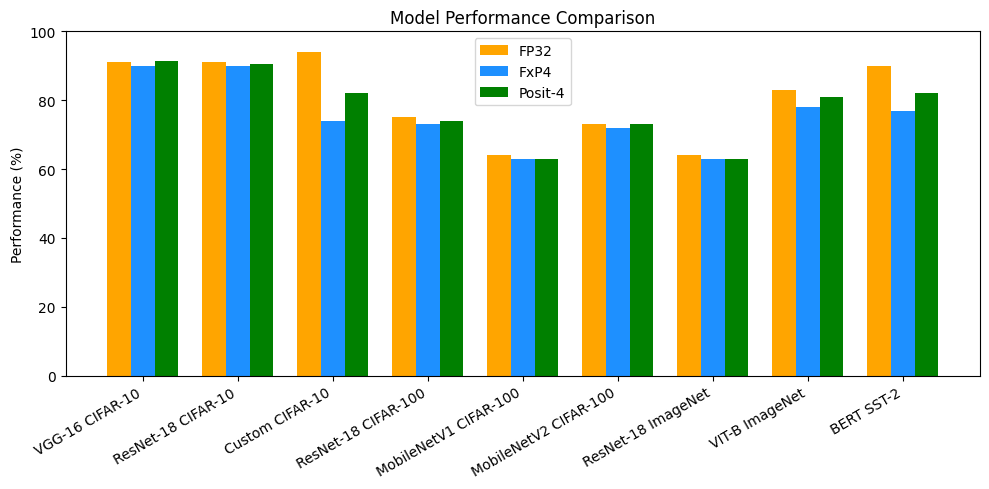

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "VGG-16 CIFAR-10",
    "ResNet-18 CIFAR-10",
    "Custom CIFAR-10",
    "ResNet-18 CIFAR-100",
    "MobileNetV1 CIFAR-100",
    "MobileNetV2 CIFAR-100",
    "ResNet-18 ImageNet",
    "VIT-B ImageNet",
    "BERT SST-2"
]

fp32 = [91, 91, 94, 75, 64, 73, 64, 83, 90]
fxp4 = [90, 90, 74, 73, 63, 72, 63, 78, 77]
posit4 = [91.5, 90.5, 82, 74, 63, 73, 63, 81, 82]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, fp32, width, label='FP32', color='orange')
ax.bar(x, fxp4, width, label='FxP4', color='dodgerblue')
ax.bar(x + width, posit4, width, label='Posit-4', color='green')

ax.set_ylabel('Performance (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right')
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()
